In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.expand_frame_repr', False)
plt.rcParams['figure.figsize'] = [15, 10]
pd.set_option('display.max_colwidth', -1)

Functions to read the results of the executions and preprocess them.

In [3]:
def read_results(list_folders):
    df_results = pd.DataFrame()
    for folder in list_folders:
        for file in os.listdir(folder):
            if not file.endswith('.csv'):
                continue
                # raise NameError('The file must be .csv')
            df = pd.read_csv(folder + file, sep=';')
            df['file'] = file
            df_results = df_results.append(df)

    return df_results

#read_results(['../results/final_results/base_predictors/', '../results/final_results/tops_v7_hoeff_0/'])

In [4]:
def check_no_missing_datasets(df_results):
    allDatasets = df_results.dataset.unique()
    for predictor in df_results.predictor.unique():
        datasetsPred = df_results.dataset[df_results.predictor == predictor].unique()
        if len(allDatasets) != len(datasetsPred) or not(allDatasets == datasetsPred).all():
            print('The predictor', predictor, "doesn't have all the datasets")

In [5]:
def eliminate_pred_wrong_exec(df_results):
    predictors = df_results.predictor.unique()
    eliminated_predictors = []
    for predictor in predictors:
        if any(df_results.loc[df_results.predictor == predictor, 'exec_time'] == 0):
            df_results = df_results.loc[df_results.predictor != predictor, :]
            eliminated_predictors.append(predictor)
    return df_results, eliminated_predictors

In [6]:
def eliminate_predictors(df_results, list_patterns):
    predictors = df_results.predictor.unique()
    eliminated_predictors = []
    for predictor in predictors:
        for patterns in list_patterns:
            if all(pattern in predictor for pattern in patterns):
                eliminated_predictors.append(predictor)
                break
    
    for predictor in eliminated_predictors:
        df_results = df_results.loc[df_results.predictor != predictor, :]
        
    return df_results
        

In [7]:
def eliminate_nas(df_results):
    rows_nas = df_results.mean_accuracy.isna() > 0
    datasets_na = df_results['dataset'][rows_nas].unique()
    for dataset in datasets_na:
        df_results = df_results.loc[df_results['dataset'] != dataset, :]
    return df_results, datasets_na

In [8]:
def get_goodness_metrics(df_results):
    goodness_metrics = [name.split("_")[1] for name in df_results.columns if 'mean_' in name]
    return goodness_metrics

def get_predictors(df_results):
    predictors = df_results.predictor.unique()
    return predictors

In [9]:
def get_alias(predictor):
    def get_base_predictors(str_base_predictors):
        # To shorten the names of the base predictors
        d = {'LogisticRegression': 'LR', 'DecisionTreeClassifier': 'DT', 'RandomForestClassifier': 'RF', 'GaussianNB': 'NB'}
        list_base_predictors = []
        for base_predictor in str_base_predictors.split('), '):
            name_pred = base_predictor[:base_predictor.find('(')]
            list_base_predictors.append(d[name_pred])
        return ', '.join(list_base_predictors)
    
    def get_attr_value(predictor, attr_name):
        start = predictor.find(attr_name + '=') + len(attr_name) + 1
        length = predictor[start:].find(',')
        length = max(-len(predictor[start:]) * length - 1, length)
        return predictor[start:start + length]
    
    def process_split(split):
        if split.startswith('SplitPercentile'):
            split = split.replace('n_bins=', '')
            split = split.replace('SplitPercentile', 'perc')
        elif split.startswith('SplitImpurity'):
            split = 'imp'
        elif split.startswith('SplitOriginal'):
            split = 'orig'
        return split
            
    if predictor.startswith('ToPs'):
        str_base_predictors = predictor[predictor.find('[') + 1:predictor.find(']')]
        proc_base_predictors = get_base_predictors(str_base_predictors)
        cv1 = get_attr_value(predictor, 'cv1')
        cv2 = get_attr_value(predictor, 'cv2')
        version = get_attr_value(predictor, 'version')
        hoeffding_prob = get_attr_value(predictor, 'min_prob_hoeffding')
        split = process_split(get_attr_value(predictor, 'split_type'))
        return 'ToPs(' + proc_base_predictors + ')[' + 'cv1=' + cv1 + ', cv2=' + cv2 + \
    ', split=' + split + ', hoeff=' + hoeffding_prob + ']'
        
    elif predictor.startswith('AdaBoost'):
        pattern = 'base_estimator='
        str_base_predictors = predictor[predictor.find(pattern) + len(pattern):predictor.find(')')]
        proc_base_predictors = get_base_predictors(str_base_predictors)
        return 'Adaboost(' + proc_base_predictors + ')'
    
    else:
        return get_base_predictors(predictor)
    
# predictors = df_results.predictor.unique()
# for predictor in predictors:
#     print(get_alias(predictor))

In [10]:
def get_datasets_appear_all_predictors(df):
    datasets = set(df.dataset)
    for predictor in df.predictor.unique():
        datasets = datasets.intersection(df.loc[df.predictor == predictor, 'dataset'])
    rows = df.dataset.apply(lambda x: x in datasets)
    df = df.loc[rows, :]
    return df

#get_datasets_appear_all_predictors(df_results)

In [11]:
list_folders = ['../results/final_results/base_predictors/', '../results/final_results/tops_v8_hoeff_0/',
               '../results/final_results/tops_v8_hoeff_08/', '../results/final_results/tops_v8_hoeff_0_imp/']
df_results = read_results(list_folders)
df_results.predictor = df_results.predictor.apply(get_alias)
df_results, eliminated_predictors = eliminate_pred_wrong_exec(df_results)
df_results = eliminate_predictors(df_results, [['cv1=10']])
df_results, datasets_na = eliminate_nas(df_results)
df_results = get_datasets_appear_all_predictors(df_results)
goodness_metrics = get_goodness_metrics(df_results)
goodness_metrics_mean = ['mean_' + metric for metric in goodness_metrics] + ['exec_time']
predictors = get_predictors(df_results)
# d_alias = dict((get_alias(predictor), predictor) for predictor in predictors)

print("List of eliminated datasets:")
print(sorted(datasets_na))
print(len(datasets_na))
print()
print("Eliminated predictors due to wrong executions:")
print(eliminated_predictors)
print()
print(check_no_missing_datasets(df_results))
print()
print("The available goodness metrics are:")
print(goodness_metrics)
print()
print("The available predictors are:")
for i, predictor in enumerate(predictors):
    print(str(i) + '.-', predictor)
    print()

List of eliminated datasets:
[]
0

Eliminated predictors due to wrong executions:
[]

None

The available goodness metrics are:
['accuracy', 'auc', 'precision', 'recall', 'f1']

The available predictors are:
0.- LR

1.- DT

2.- NB

3.- RF

4.- ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]

5.- ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]

6.- ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]

7.- ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]

8.- ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]

9.- ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]

10.- ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]

11.- ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]

12.- ToPs(DT)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]

13.- ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]

14.- ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]

15.- ToPs(NB)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]



Now we will compare the mean metrics for pairs of predictors

In [12]:
all_predictors_1 = ['LR', 'ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]',
                   'DT', 'ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]',
                   'NB', 'ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]',
                    'ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]']
all_tops_1 = ['ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]',
              'ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]',
              'ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]',
              'ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]']
list_pairs_base_classifier_vs_tops = [('LR', 'ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]'), 
                                      ('DT', 'ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]'),
                                      ('NB', 'ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]')]


all_predictors_2 = ['ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]',
                   'ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]',
                   'ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]',
                   'ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]']
list_pairs_orig_vs_hoeff = [('ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]'), 
                            ('ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]'),
                            ('ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]'),
                            ('ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]')]


all_predictors_3 = ['ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]',
                   'ToPs(DT)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]',
                   'ToPs(NB)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]',
                   'ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]']
list_pairs_orig_vs_imp = [('ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]'), 
                            ('ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(DT)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]'),
                            ('ToPs(NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(NB)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]'),
                            ('ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]', 'ToPs(LR, RF, DT, NB)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]')]


list_pairs_rf_vs_tops = [('RF', 'ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]')]

In [13]:
def print_mean_metrics(df, list_pairs, metrics, to_latex=False):
    for pred1, pred2 in list_pairs:
        df_pred1 = df.loc[df['predictor'] == pred1, :]
        df_pred2 = df.loc[df['predictor'] == pred2, :]
        mean_metrics1 = df_pred1.groupby('predictor').mean()[metrics]
        mean_metrics2 = df_pred2.groupby('predictor').mean()[metrics]
        both_metrics = pd.DataFrame(mean_metrics1)
        both_metrics = both_metrics.append(mean_metrics2)
        both_metrics.columns = [elem.split('_')[-1] for elem in both_metrics.columns]
        both_metrics = both_metrics.round(3)
        if not to_latex:
            print(both_metrics)
        else:
            print(both_metrics.to_latex())
        print()

In [14]:
def plot_2_metrics(df, list_pred, metric_x, metric_y):
    for pred in list_pred:
        df_aux = df.loc[df['predictor'] == pred, [metric_x, metric_y]].sort_values([metric_x])
        plt.plot(df_aux[metric_x], df_aux[metric_y], label=pred)
        
    plt.title(metric_y + ' vs ' + metric_x)
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.show()

In [15]:
def plot_metric(df_results, goodness_metric, predictors):
    mean_goodness_metric = 'mean_' + goodness_metric
    std_dev_metric = 'std_' + goodness_metric
    # set width of bar
    barWidth = 0.15
    max_n_datasets = 20
    unique_datasets = np.sort(np.unique(df_results.dataset))
    colors = [np.random.rand(3) for _ in range(len(predictors))]

    for i in range(len(unique_datasets) // max_n_datasets + 1):
        datasets = unique_datasets[i * max_n_datasets: (i + 1) * max_n_datasets]
        current_df_results = df_results.loc[(datasets[0] <= df_results.dataset) &
                                            (df_results.dataset <= datasets[-1]), :]

        for i, predictor in enumerate(predictors):
            acc = current_df_results.loc[current_df_results.predictor == predictor, mean_goodness_metric]
            stdev_acc = current_df_results.loc[current_df_results.predictor == predictor, std_dev_metric] + 0.003

            # Set position of bar on X axis
            r_base = np.arange(len(datasets))
            r = [x + barWidth*i for x in r_base]

            # Make the plot
            plt.bar(r, 2*stdev_acc, bottom=acc - stdev_acc, color=colors[i], width=barWidth, edgecolor='white', label=predictor)

        # Add xticks on the middle of the group bars
        # plt.xlabel('datasets', fontweight='bold')
        plt.xticks([r + barWidth * len(predictors) / 2 for r in range(max_n_datasets)], datasets, rotation='vertical')

        # Create legend & Show graphic
        plt.legend()
        plt.grid()
        plt.show()

# ToPs orig

First analysis of the mean values for the performance metrics

In [16]:
print_mean_metrics(df_results, list_pairs_base_classifier_vs_tops, goodness_metrics_mean)

                                                    accuracy    auc  precision  recall     f1      time
predictor                                                                                              
LR                                                  0.866     0.947  0.862      0.866   0.012  5.435   
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]  0.894     0.963  0.892      0.894   0.013  1146.931

                                                    accuracy    auc  precision  recall     f1     time
predictor                                                                                             
DT                                                  0.873     0.914  0.873      0.873   0.011  3.084  
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]  0.872     0.931  0.872      0.872   0.011  574.418

                                                    accuracy    auc  precision  recall     f1     time
predictor                                                          

In [17]:
print_mean_metrics(df_results, list_pairs_base_classifier_vs_tops, goodness_metrics_mean, True)

\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &    auc &  precision &  recall &     f1 &      time \\
predictor                                          &           &        &            &         &        &           \\
\midrule
LR                                                 &  0.866 &  0.947 &  0.862 &  0.866 &  0.012 &  5.435 \\
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0] &  0.894 &  0.963 &  0.892 &  0.894 &  0.013 &  1146.931 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &    auc &  precision &  recall &     f1 &     time \\
predictor                                          &           &        &            &         &        &          \\
\midrule
DT                                                 &  0.873 &  0.914 &  0.873 &  0.873 &  0.011 &  3.084 \\
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0] &  0.872 &  0.931 &  0.872 &  0.872 &  0.011 &  574.418 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
{} &  acc

Let's see how the execution time behaves as a function of the number of instances and features

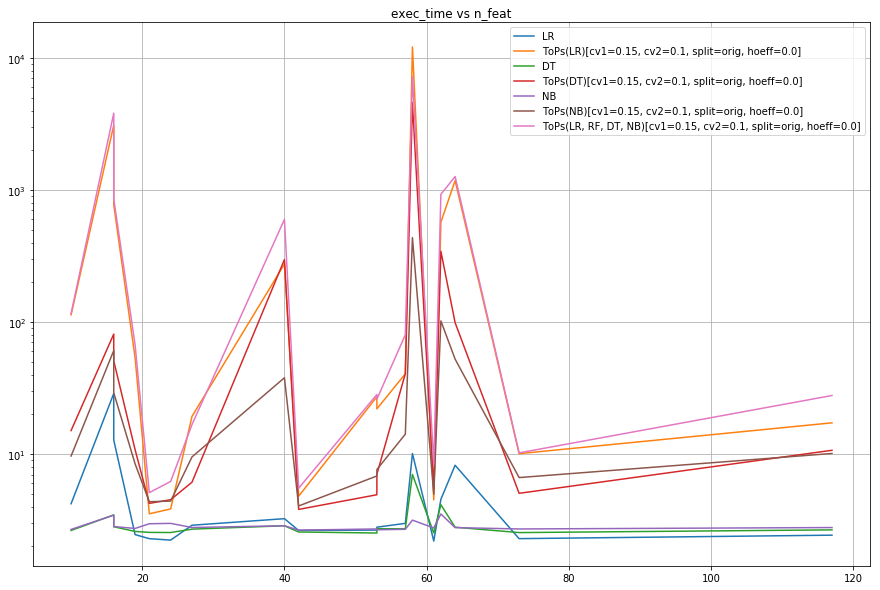

In [18]:
df_not_splice = df_results.loc[df_results.dataset != 'splice.arff', :]
plot_2_metrics(df_not_splice, all_predictors_1, 'n_feat', 'exec_time')

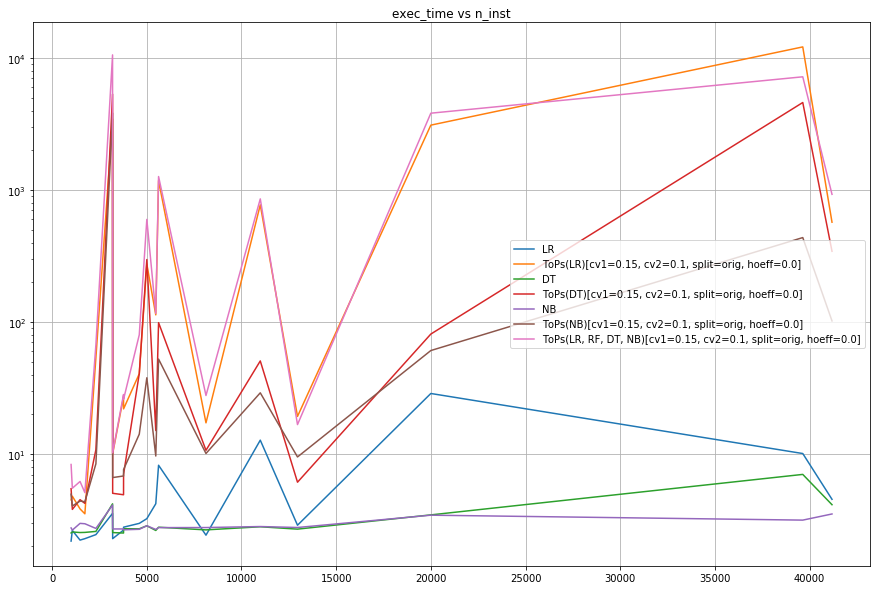

In [19]:
plot_2_metrics(df_results, all_predictors_1, 'n_inst', 'exec_time')

Try to see the accuracy of pair of predictors for each dataset. We also plot the stdev of the 5 executions to see if the difference of accuracy is significant or not.

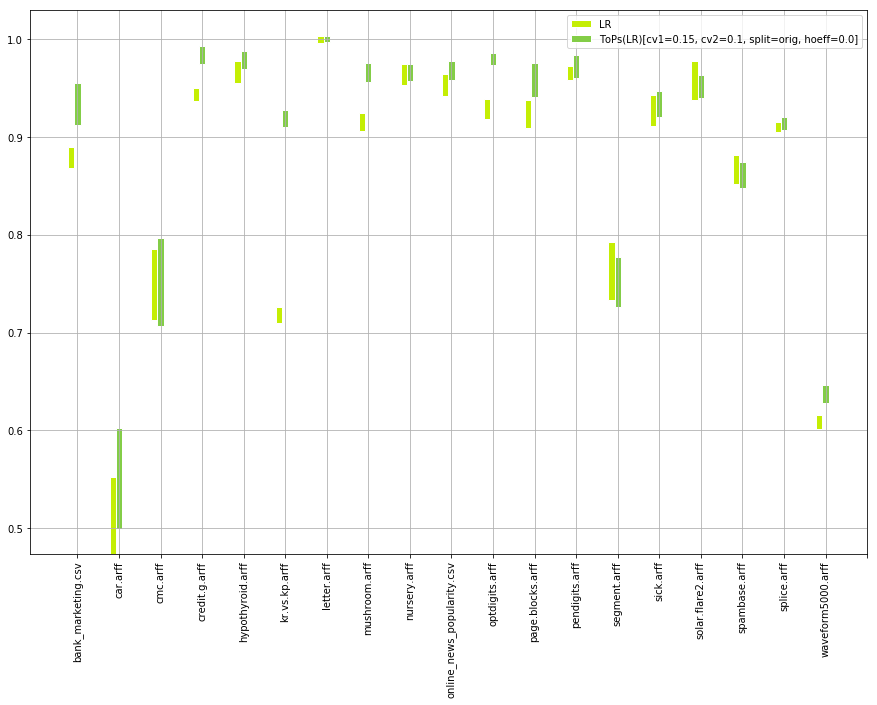

In [20]:
plot_metric(df_results, 'accuracy', list_pairs_base_classifier_vs_tops[0])

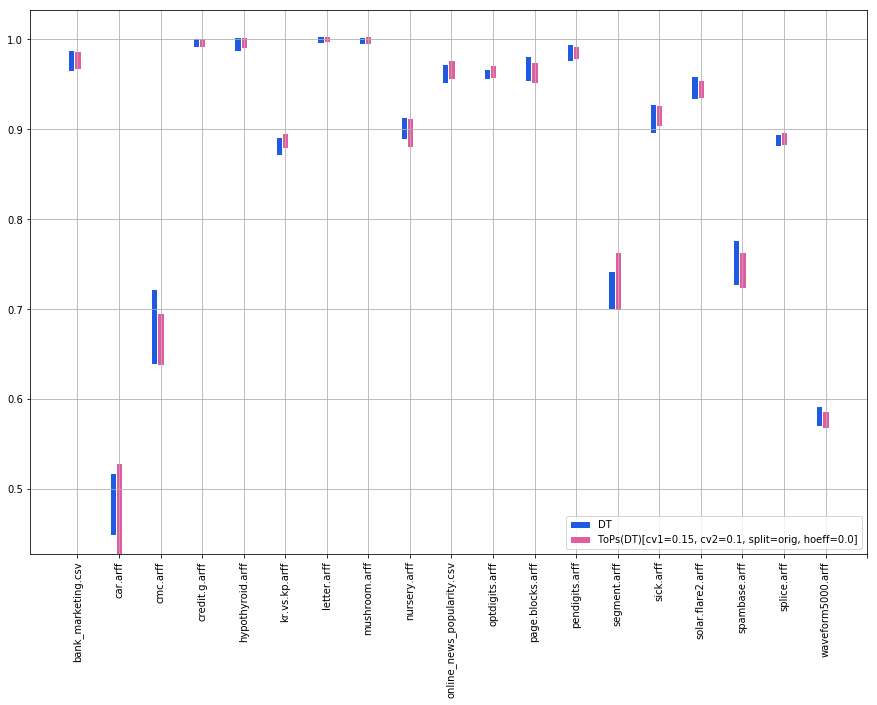

In [21]:
plot_metric(df_results, 'accuracy', list_pairs_base_classifier_vs_tops[1])

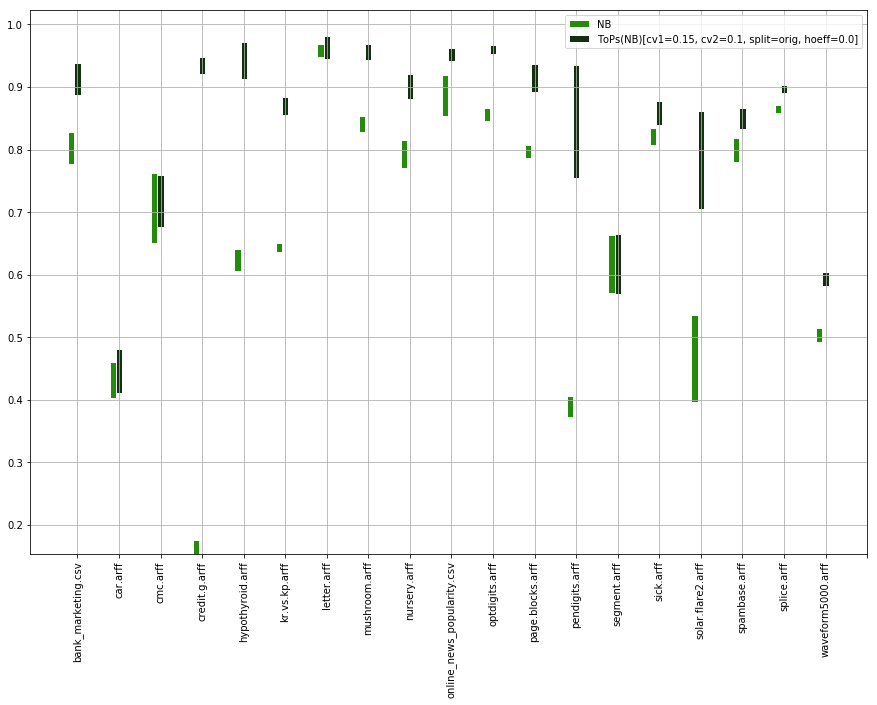

In [22]:
plot_metric(df_results, 'accuracy', list_pairs_base_classifier_vs_tops[2])

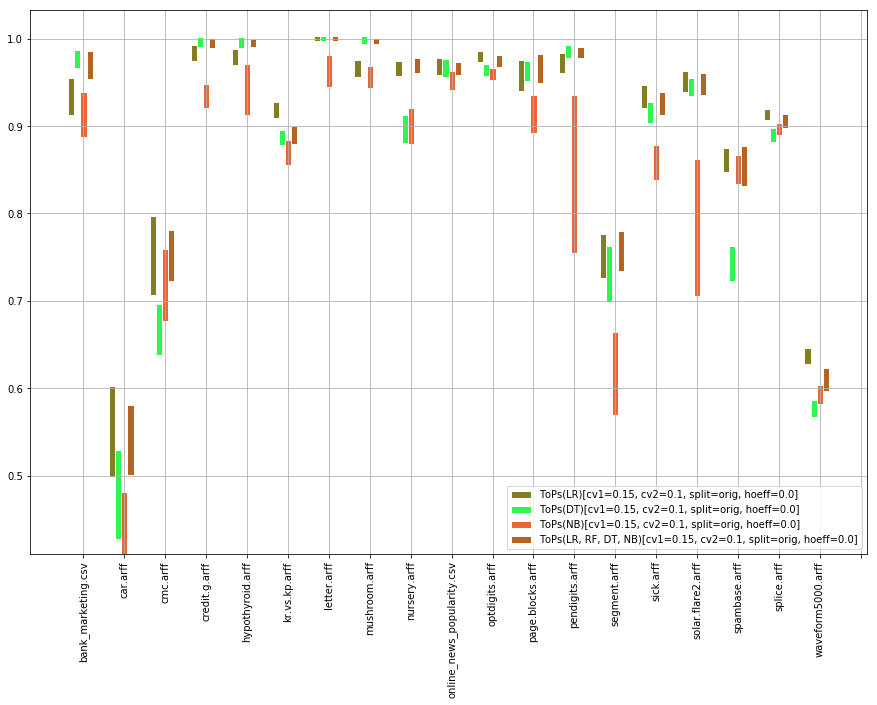

In [23]:
plot_metric(df_results, 'accuracy', all_tops_1)

# Results  for hoeff=0.8

First analysis of the mean values for the performance metrics

In [24]:
print_mean_metrics(df_results, list_pairs_orig_vs_hoeff, goodness_metrics_mean)

                                                    accuracy    auc  precision  recall     f1      time
predictor                                                                                              
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]  0.894     0.963  0.892      0.894   0.013  1146.931
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]  0.885     0.961  0.883      0.885   0.015  560.413 

                                                    accuracy    auc  precision  recall     f1     time
predictor                                                                                             
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]  0.872     0.931  0.872      0.872   0.011  574.418
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8]  0.871     0.922  0.872      0.871   0.010  250.162

                                                    accuracy    auc  precision  recall     f1     time
predictor                                                          

In [25]:
print_mean_metrics(df_results, list_pairs_orig_vs_hoeff, goodness_metrics_mean, True)

\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &    auc &  precision &  recall &     f1 &      time \\
predictor                                          &           &        &            &         &        &           \\
\midrule
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0] &  0.894 &  0.963 &  0.892 &  0.894 &  0.013 &  1146.931 \\
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8] &  0.885 &  0.961 &  0.883 &  0.885 &  0.015 &  560.413 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &    auc &  precision &  recall &     f1 &     time \\
predictor                                          &           &        &            &         &        &          \\
\midrule
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0] &  0.872 &  0.931 &  0.872 &  0.872 &  0.011 &  574.418 \\
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.8] &  0.871 &  0.922 &  0.872 &  0.871 &  0.010 &  250.162 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
{} & 

Let's see how the execution time behaves as a function of the number of instances and features

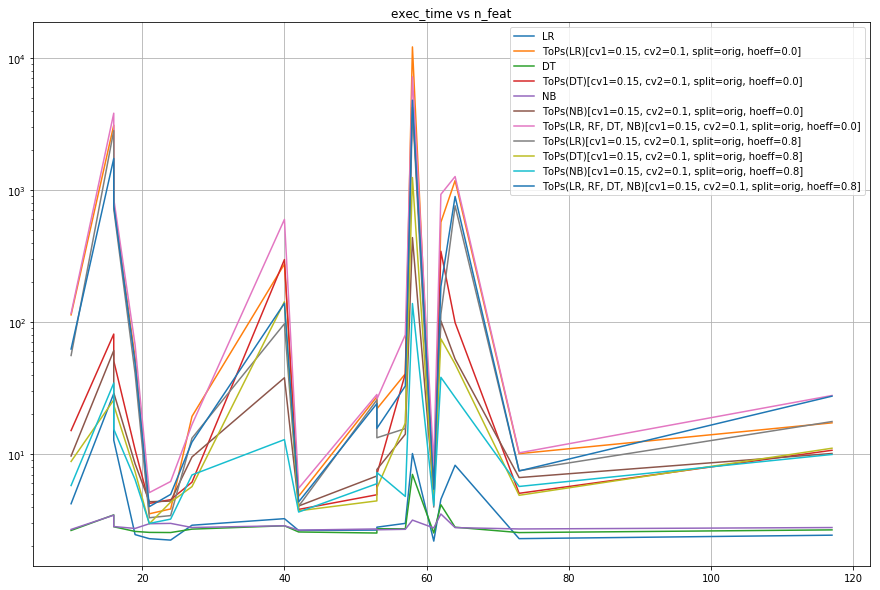

In [26]:
df_not_splice = df_results.loc[df_results.dataset != 'splice.arff', :]
plot_2_metrics(df_not_splice, all_predictors_1 + all_predictors_2, 'n_feat', 'exec_time')

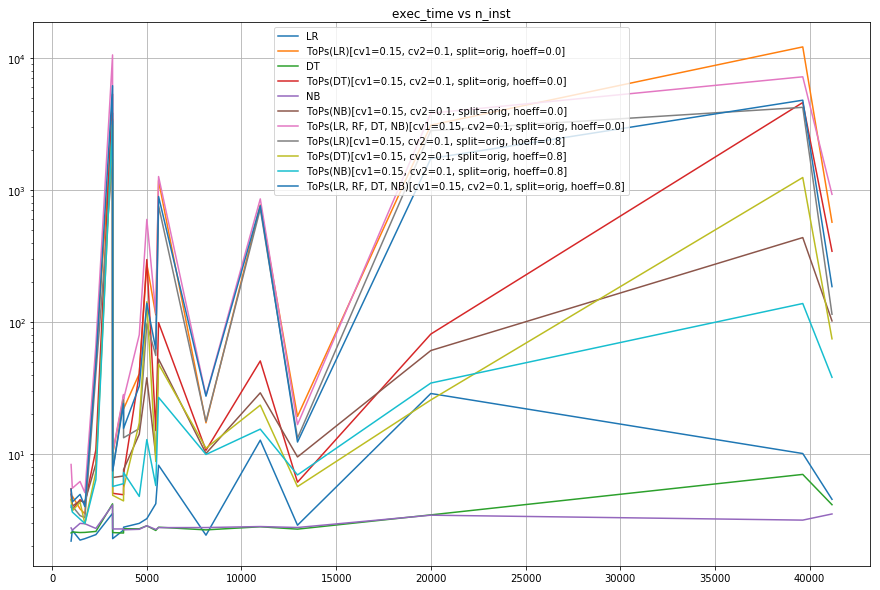

In [27]:
plot_2_metrics(df_results, all_predictors_1 + all_predictors_2, 'n_inst', 'exec_time')

Try to see the accuracy of pair of predictors for each dataset. We also plot the stdev of the 5 executions to see if the difference of accuracy is significant or not.

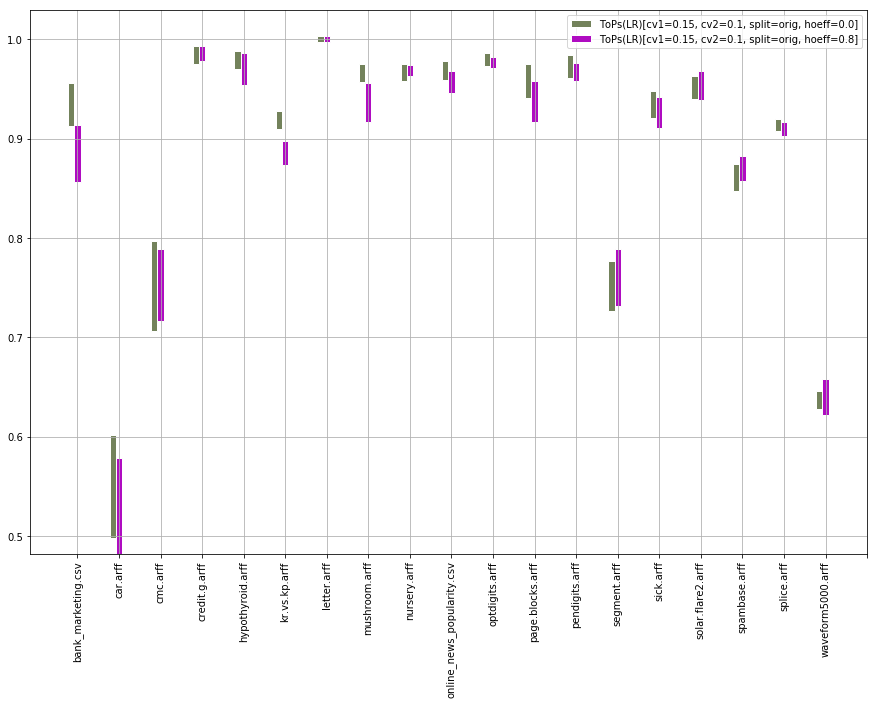

In [28]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_hoeff[0])

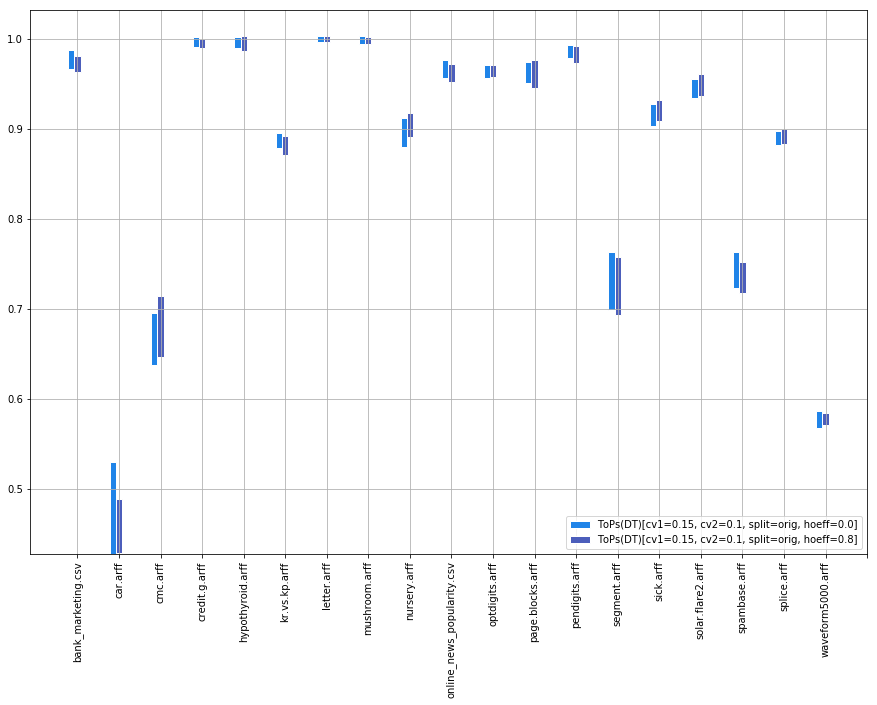

In [29]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_hoeff[1])

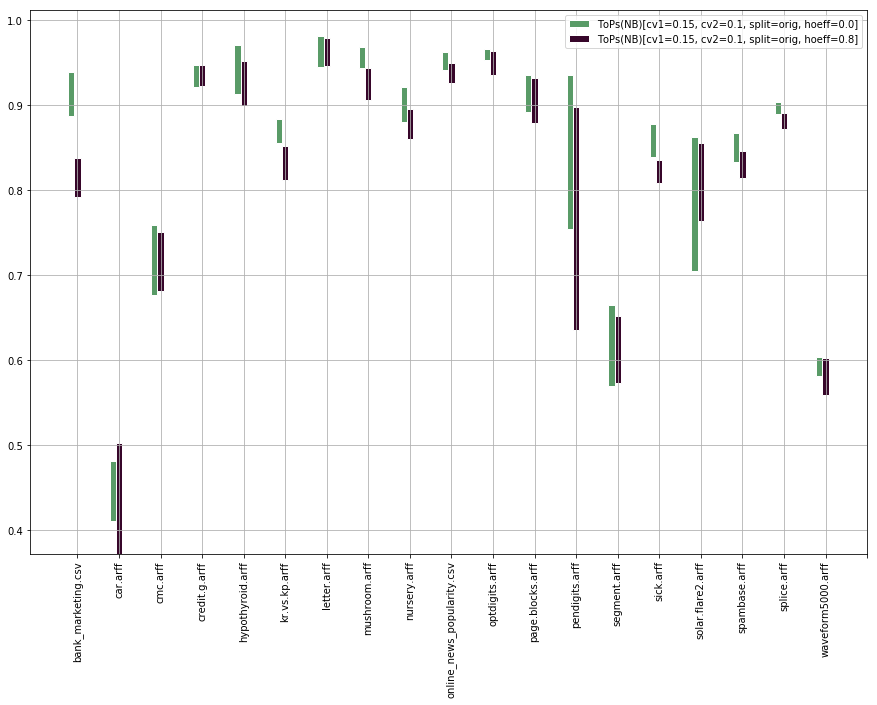

In [30]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_hoeff[2])

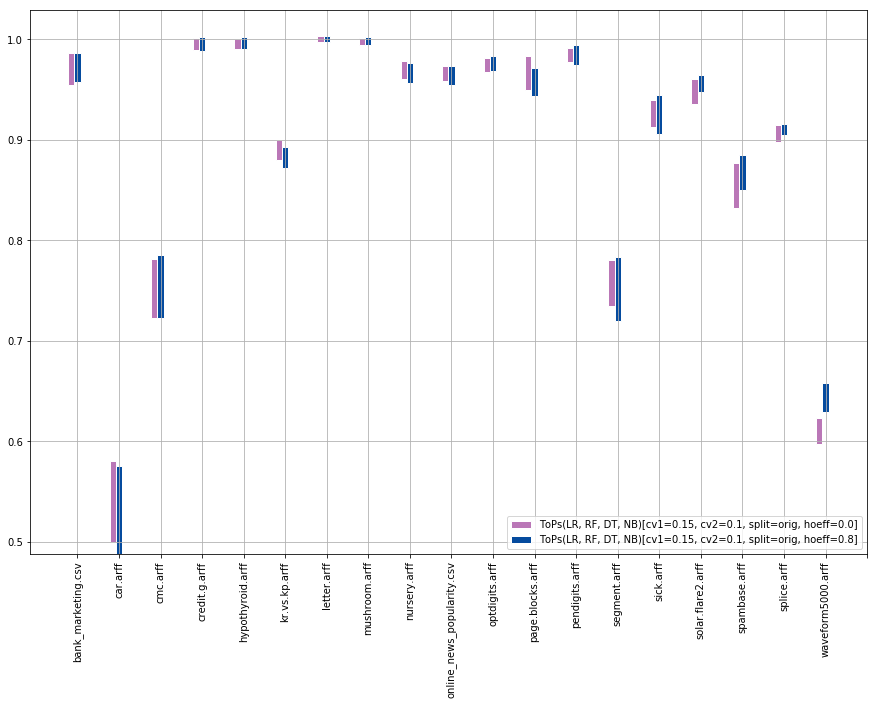

In [31]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_hoeff[3])

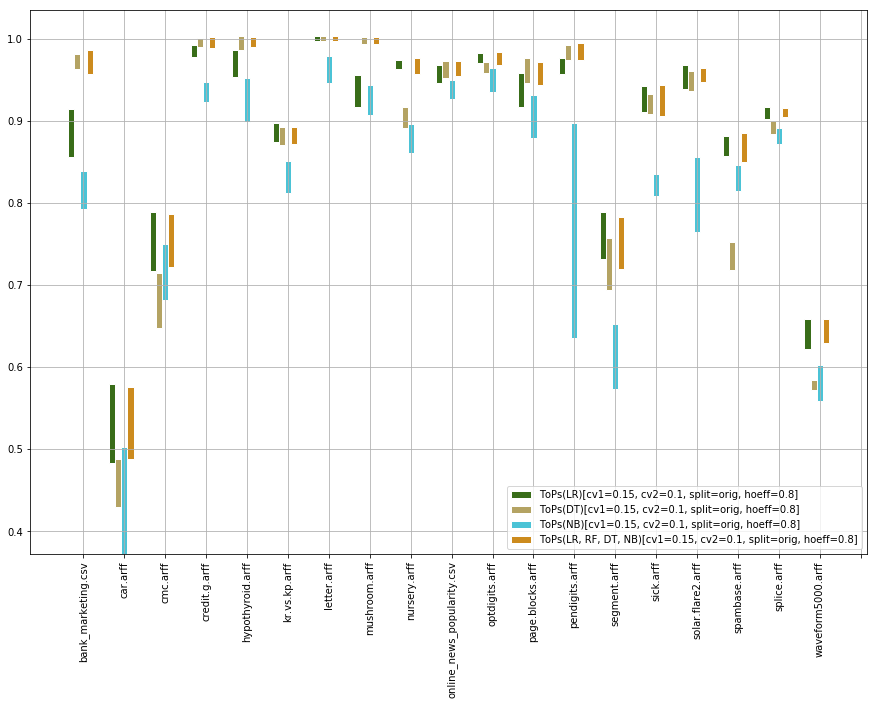

In [32]:
plot_metric(df_results, 'accuracy', all_predictors_2)

# Results for imp

First analysis of the mean values for the performance metrics

In [33]:
print_mean_metrics(df_results, list_pairs_orig_vs_imp, goodness_metrics_mean)

                                                    accuracy    auc  precision  recall     f1      time
predictor                                                                                              
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]  0.894     0.963  0.892      0.894   0.013  1146.931
ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]   0.891     0.964  0.889      0.891   0.013  384.857 

                                                    accuracy    auc  precision  recall     f1     time
predictor                                                                                             
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0]  0.872     0.931  0.872      0.872   0.011  574.418
ToPs(DT)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]   0.872     0.925  0.872      0.872   0.011  444.889

                                                    accuracy    auc  precision  recall     f1     time
predictor                                                          

In [34]:
print_mean_metrics(df_results, list_pairs_orig_vs_imp, goodness_metrics_mean, True)

\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &    auc &  precision &  recall &     f1 &      time \\
predictor                                          &           &        &            &         &        &           \\
\midrule
ToPs(LR)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0] &  0.894 &  0.963 &  0.892 &  0.894 &  0.013 &  1146.931 \\
ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]  &  0.891 &  0.964 &  0.889 &  0.891 &  0.013 &  384.857 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &    auc &  precision &  recall &     f1 &     time \\
predictor                                          &           &        &            &         &        &          \\
\midrule
ToPs(DT)[cv1=0.15, cv2=0.1, split=orig, hoeff=0.0] &  0.872 &  0.931 &  0.872 &  0.872 &  0.011 &  574.418 \\
ToPs(DT)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]  &  0.872 &  0.925 &  0.872 &  0.872 &  0.011 &  444.889 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
{} & 

Let's see how the execution time behaves as a function of the number of instances and features

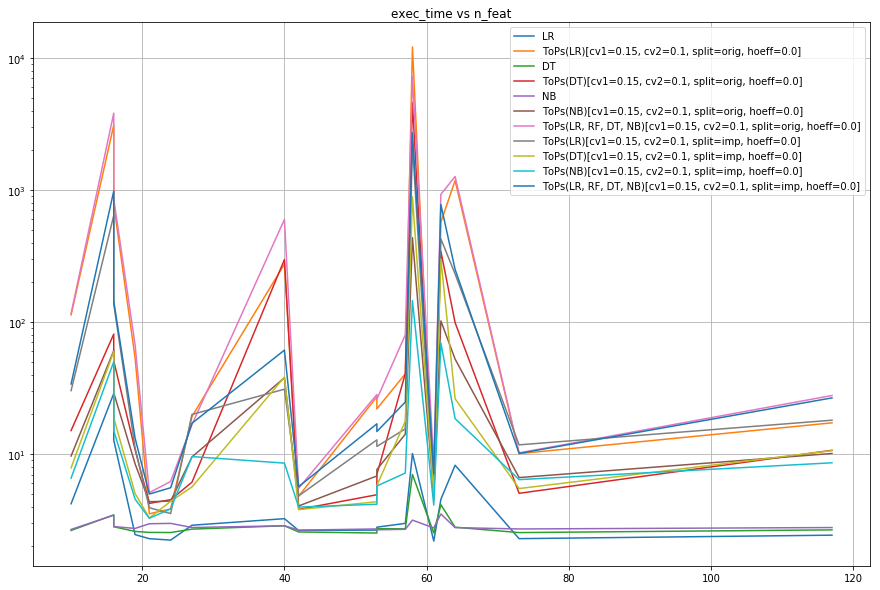

In [35]:
df_not_splice = df_results.loc[df_results.dataset != 'splice.arff', :]
plot_2_metrics(df_not_splice, all_predictors_1 + all_predictors_3, 'n_feat', 'exec_time')

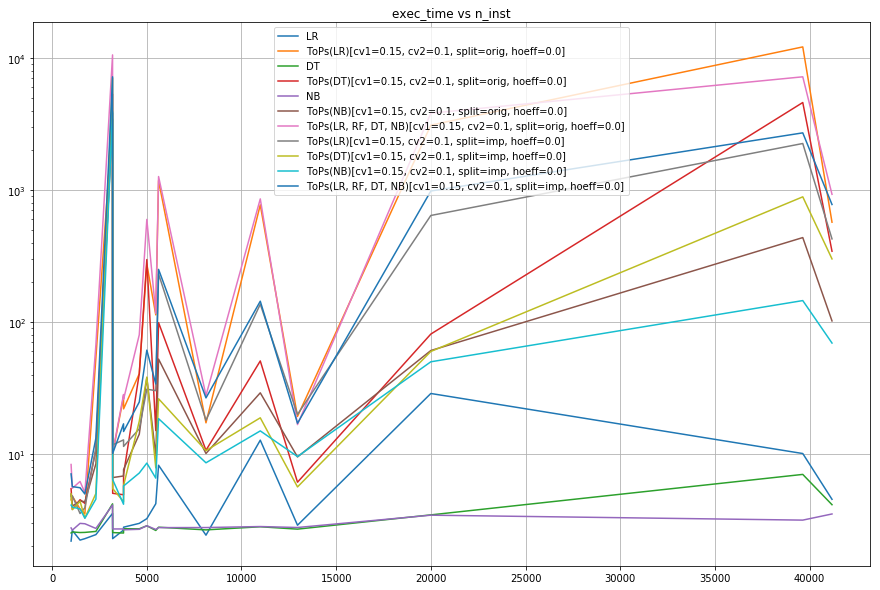

In [36]:
plot_2_metrics(df_results, all_predictors_1 + all_predictors_3, 'n_inst', 'exec_time')

Try to see the accuracy of pair of predictors for each dataset. We also plot the stdev of the 5 executions to see if the difference of accuracy is significant or not.

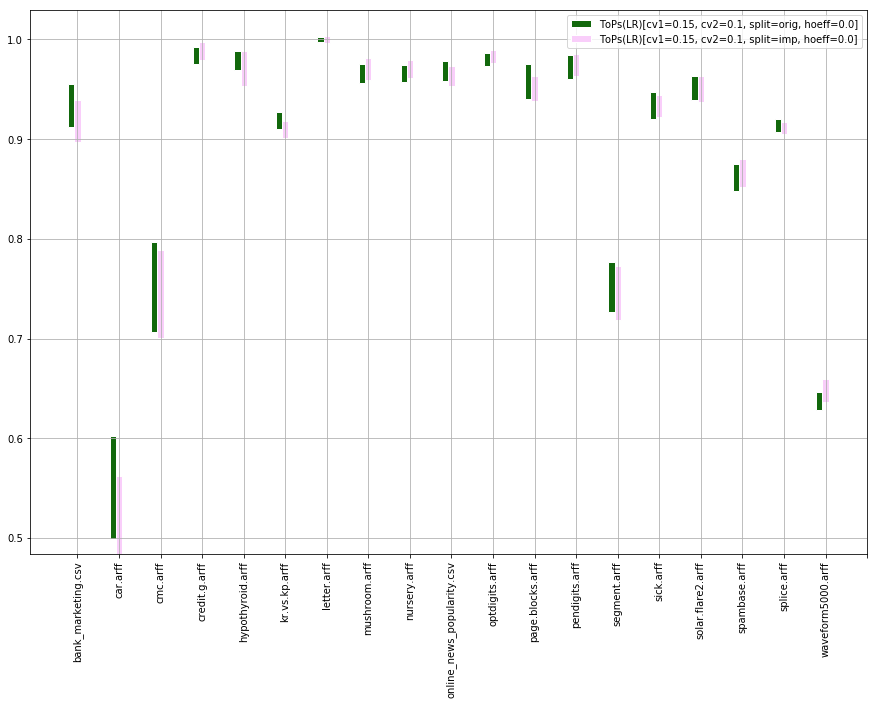

In [37]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_imp[0])

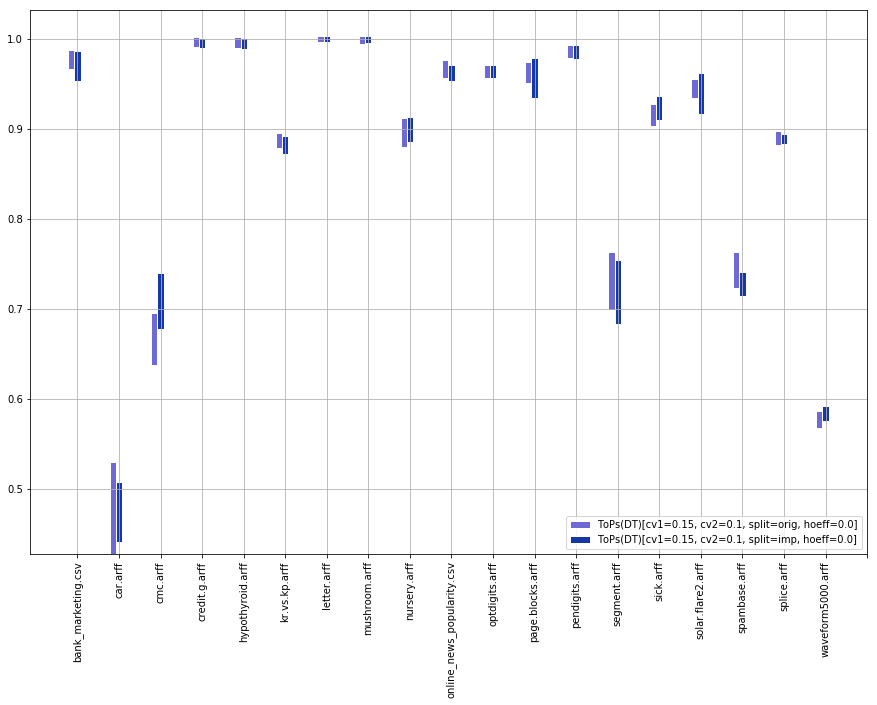

In [38]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_imp[1])

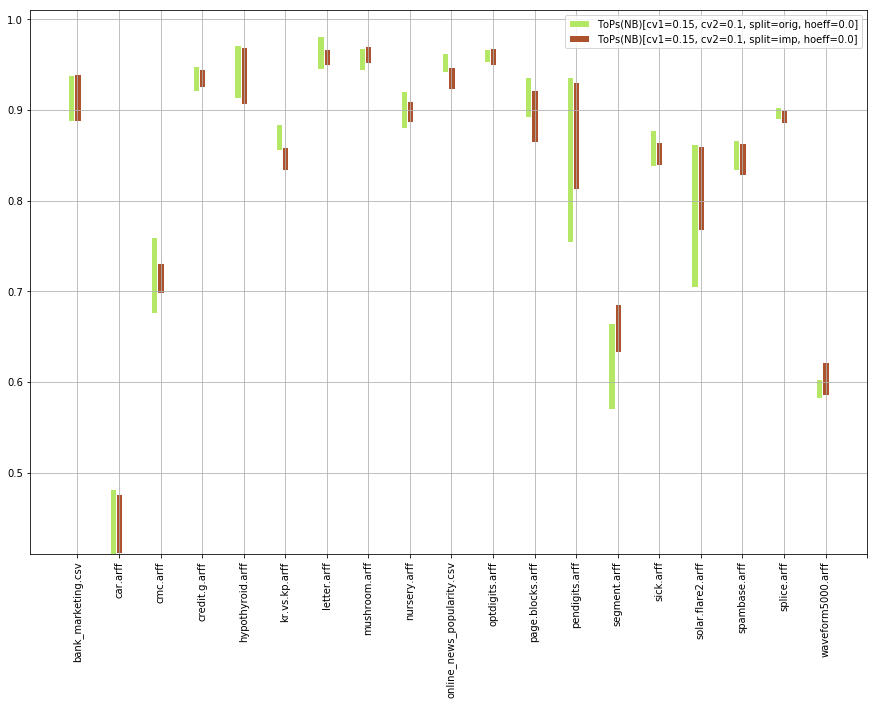

In [39]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_imp[2])

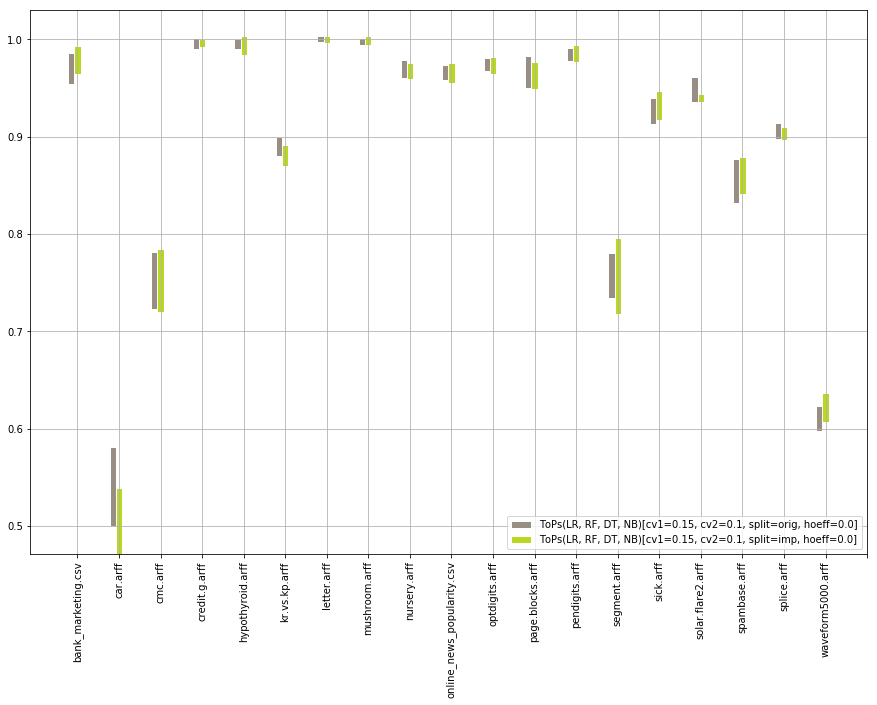

In [40]:
plot_metric(df_results, 'accuracy', list_pairs_orig_vs_imp[3])

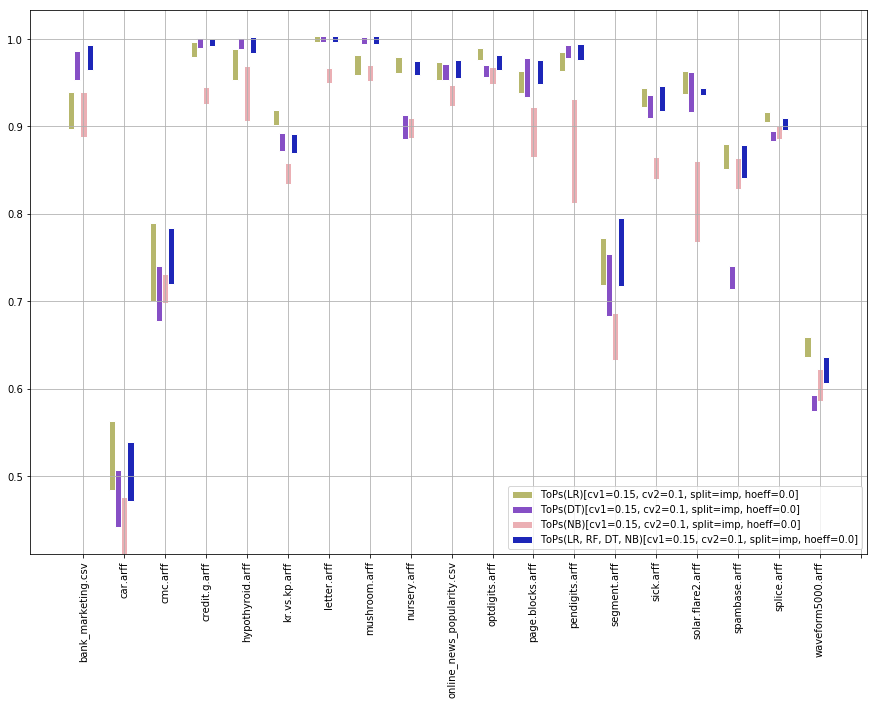

In [41]:
plot_metric(df_results, 'accuracy', all_predictors_3)

In [42]:
print_mean_metrics(df_results, list_pairs_rf_vs_tops, goodness_metrics_mean)

                                                   accuracy    auc  precision  recall     f1     time
predictor                                                                                            
RF                                                 0.903     0.963  0.902      0.903   0.010  20.162 
ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0]  0.891     0.964  0.889      0.891   0.013  384.857



In [43]:
print_mean_metrics(df_results, list_pairs_rf_vs_tops, goodness_metrics_mean, True)

\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &    auc &  precision &  recall &     f1 &     time \\
predictor                                         &           &        &            &         &        &          \\
\midrule
RF                                                &  0.903 &  0.963 &  0.902 &  0.903 &  0.010 &  20.162 \\
ToPs(LR)[cv1=0.15, cv2=0.1, split=imp, hoeff=0.0] &  0.891 &  0.964 &  0.889 &  0.891 &  0.013 &  384.857 \\
\bottomrule
\end{tabular}




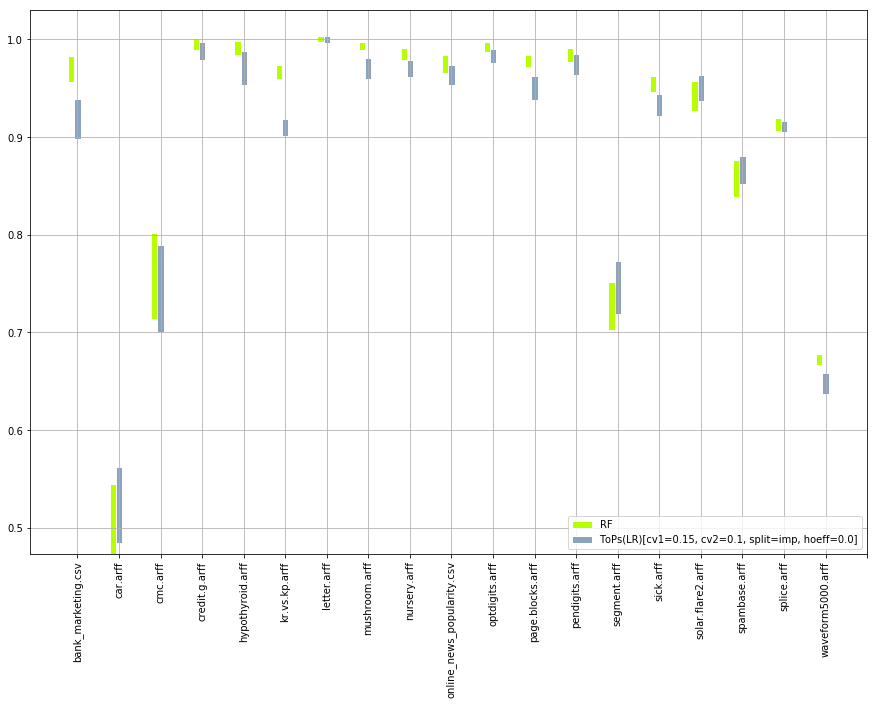

In [48]:
plot_metric(df_results, 'accuracy', list_pairs_rf_vs_tops[0])

In [45]:
df_results

,dataset,n_inst,n_feat,n_feat_num,n_feat_cat,n_classes,predictor,mean_accuracy,std_accuracy,mean_auc,std_auc,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,exec_time,file
0,car.arff,1728,21,21,0,4,LR,0.879072,0.008172,0.982482,0.003312,0.884084,0.008421,0.879072,0.008172,0.009794,0.009794,2.287880,2019-06-12_23-51-19_rep1_CV8.csv
1,cmc.arff,1473,24,24,0,3,LR,0.513154,0.036394,0.694491,0.042313,0.505927,0.039371,0.513154,0.036394,0.039033,0.039033,2.231364,2019-06-12_23-51-19_rep1_CV8.csv
2,credit.g.arff,1000,61,61,0,2,LR,0.748992,0.033160,NaN,NaN,0.736492,0.037161,0.748992,0.033160,0.035237,0.035237,2.193187,2019-06-12_23-51-19_rep1_CV8.csv
3,hypothyroid.arff,3770,53,53,0,3,LR,0.943238,0.003452,0.872987,0.028654,0.922317,0.024552,0.943238,0.003452,0.006018,0.006018,2.657822,2019-06-12_23-51-19_rep1_CV8.csv
4,kr.vs.kp.arff,3196,73,73,0,2,LR,0.966214,0.008284,NaN,NaN,0.966423,0.008124,0.966214,0.008284,0.008278,0.008278,2.288877,2019-06-12_23-51-19_rep1_CV8.csv
5,letter.arff,20000,16,16,0,26,LR,0.717646,0.005201,0.966160,0.001497,0.721410,0.006269,0.717646,0.005201,0.005809,0.005809,28.769993,2019-06-12_23-51-19_rep1_CV8.csv
6,mushroom.arff,8124,117,117,0,2,LR,0.999877,0.000326,NaN,NaN,0.999877,0.000325,0.999877,0.000326,0.000326,0.000326,2.431496,2019-06-12_23-51-19_rep1_CV8.csv
7,nursery.arff,12958,27,27,0,4,LR,0.915342,0.005955,0.986722,0.001568,0.893516,0.005739,0.915342,0.005955,0.005848,0.005848,2.892263,2019-06-12_23-51-19_rep1_CV8.csv
8,optdigits.arff,5620,64,64,0,10,LR,0.964245,0.007791,0.998038,0.000940,0.964697,0.007787,0.964245,0.007791,0.007772,0.007772,8.231221,2019-06-12_23-51-19_rep1_CV8.csv
9,page.blocks.arff,5473,10,10,0,5,LR,0.953412,0.007994,0.970397,0.009719,0.950754,0.010194,0.953412,0.007994,0.009374,0.009374,4.206706,2019-06-12_23-51-19_rep1_CV8.csv


In [46]:
df_results.loc[df_results.predictor == 'LR', ['dataset', 'n_inst', 'n_feat', 'n_classes']]

,dataset,n_inst,n_feat,n_classes
0,car.arff,1728,21,4
1,cmc.arff,1473,24,3
2,credit.g.arff,1000,61,2
3,hypothyroid.arff,3770,53,3
4,kr.vs.kp.arff,3196,73,2
5,letter.arff,20000,16,26
6,mushroom.arff,8124,117,2
7,nursery.arff,12958,27,4
8,optdigits.arff,5620,64,10
9,page.blocks.arff,5473,10,5


In [47]:
print(df_results.loc[df_results.predictor == 'LR', ['dataset', 'n_inst', 'n_feat', 'n_classes']].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                    dataset &  n\_inst &  n\_feat &  n\_classes \\
\midrule
 car.arff &  1728 &  21 &  4 \\
 cmc.arff &  1473 &  24 &  3 \\
 credit.g.arff &  1000 &  61 &  2 \\
 hypothyroid.arff &  3770 &  53 &  3 \\
 kr.vs.kp.arff &  3196 &  73 &  2 \\
 letter.arff &  20000 &  16 &  26 \\
 mushroom.arff &  8124 &  117 &  2 \\
 nursery.arff &  12958 &  27 &  4 \\
 optdigits.arff &  5620 &  64 &  10 \\
 page.blocks.arff &  5473 &  10 &  5 \\
 pendigits.arff &  10992 &  16 &  10 \\
 segment.arff &  2310 &  19 &  7 \\
 sick.arff &  3772 &  53 &  2 \\
 solar.flare2.arff &  1066 &  42 &  6 \\
 spambase.arff &  4601 &  57 &  2 \\
 splice.arff &  3190 &  3465 &  3 \\
 waveform5000.arff &  5000 &  40 &  3 \\
 bank\_marketing.csv &  41188 &  62 &  2 \\
 online\_news\_popularity.csv &  39644 &  58 &  2 \\
\bottomrule
\end{tabular}

